In [1]:
import os
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping
from data_utils import train_texts
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [2]:
# Define constants
MAX_WORDS = 8000  # Vocabulary size
MAX_SEQUENCE_LENGTH = 500  # Max number of words per review
EMBEDDING_DIM = 100  # Dimension of word embeddings
BATCH_SIZE = 128
NUM_EPOCHS = 15

In [3]:
# Load data
try:
    current_dir = os.path.abspath(os.path.dirname(__file__))
except NameError:
    current_dir = os.getcwd()

# Construct paths to train and test folders
train_dir = os.path.join(current_dir, 'train')
test_dir = os.path.join(current_dir, 'test')

In [4]:
# Example of populating train_texts with training text data
train_texts = []

for category in ['neg', 'pos']:
    category_dir = os.path.join(train_dir, category)
    for filename in os.listdir(category_dir):
        if filename.endswith('.txt'):
            file_path = os.path.join(category_dir, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                train_texts.append(file.read())

In [5]:
# Process and tokenize texts
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train_texts)
sequences = tokenizer.texts_to_sequences(train_texts)
word_index = tokenizer.word_index

In [6]:
# Pad sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Create labels (0 for 'neg', 1 for 'pos')
labels = np.concatenate((np.zeros(len(os.listdir(os.path.join(train_dir, 'neg')))),
                         np.ones(len(os.listdir(os.path.join(train_dir, 'pos'))))))

In [7]:
# Shuffle data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [8]:
# Define CNN model
model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.8))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(1, activation='sigmoid'))

In [9]:
# Compile model
model.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train model with early stopping
history = model.fit(data, labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/15
157/157 [==============================] - 418s 3s/step - loss: 0.6923 - accuracy: 0.5127 - val_loss: 0.6479 - val_accuracy: 0.7048
Epoch 2/15
157/157 [==============================] - 529s 3s/step - loss: 0.3846 - accuracy: 0.8303 - val_loss: 0.2642 - val_accuracy: 0.8944
Epoch 3/15
157/157 [==============================] - 443s 3s/step - loss: 0.2268 - accuracy: 0.9141 - val_loss: 0.2882 - val_accuracy: 0.8892
Epoch 4/15
157/157 [==============================] - 425s 3s/step - loss: 0.1600 - accuracy: 0.9405 - val_loss: 0.2868 - val_accuracy: 0.8844
Epoch 5/15
157/157 [==============================] - 331s 2s/step - loss: 0.1229 - accuracy: 0.9548 - val_loss: 0.4112 - val_accuracy: 0.8756
Epoch 6/15
157/157 [==============================] - 349s 2s/step - loss: 0.0936 - accuracy: 0.9670 - val_loss: 0.3553 - val_accuracy: 0.8876
Epoch 7/15
157/157 [==============================] - 326s 2s/step - loss: 0.0626 - accuracy: 0.9785 - val_loss: 0.4264 - val_accuracy: 0.8874

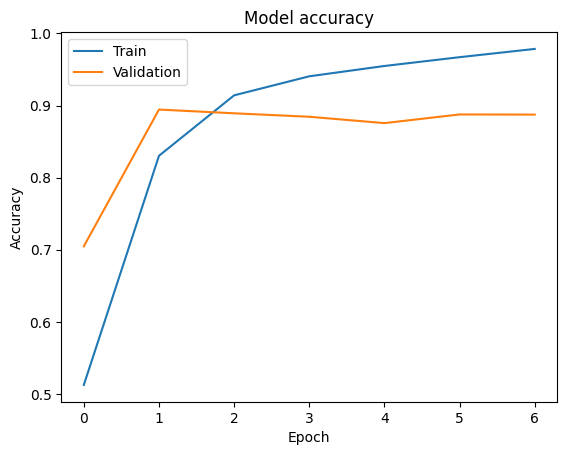

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

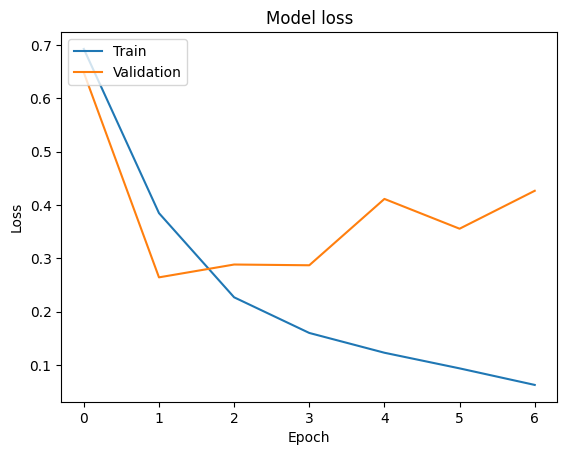

In [11]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
# Example of populating test_texts with test text data
test_texts = []

for category in ['neg', 'pos']:
    category_dir = os.path.join(test_dir, category)
    for filename in os.listdir(category_dir):
        if filename.endswith('.txt'):
            file_path = os.path.join(category_dir, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                test_texts.append(file.read())

In [13]:
# Tokenize and pad test data
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Create test labels
test_labels = np.concatenate((np.zeros(len(os.listdir(os.path.join(test_dir, 'neg')))),
                              np.ones(len(os.listdir(os.path.join(test_dir, 'pos'))))))

In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

782/782 [==============================] - 112s 143ms/step - loss: 0.2659 - accuracy: 0.8905
Test Loss: 0.26586973667144775
Test Accuracy: 0.8905199766159058


In [15]:
# Predict test labels
y_pred_prob = model.predict(test_data)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Print classification report
print(classification_report(test_labels, y_pred))

782/782 [==============================] - 145s 184ms/step
              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89     12500
         1.0       0.88      0.91      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



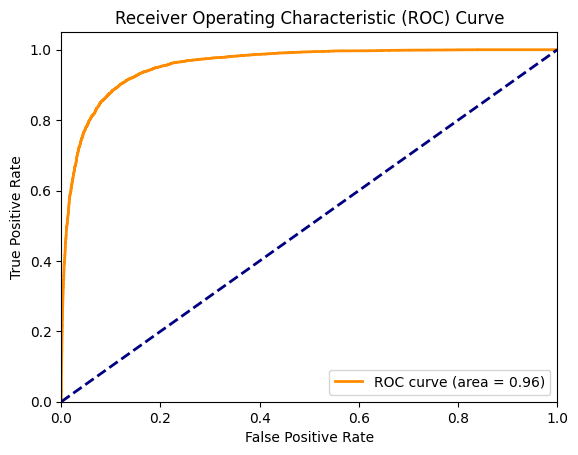

In [16]:
# Calculate probabilities for positive class
y_prob = y_pred_prob.ravel()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

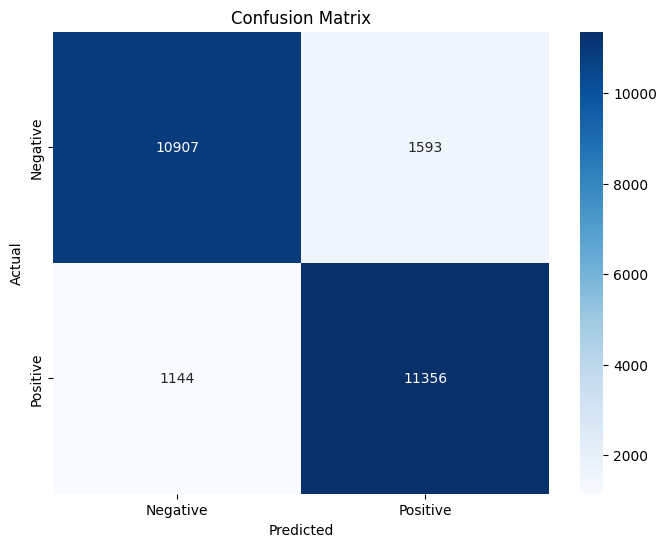

In [17]:
# Calculate and plot confusion matrix
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [18]:
# Calculate additional metrics
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

# Print metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Specificity: {specificity}')
print(f'Accuracy: {accuracy}')

Precision: 0.8769789172909105
Recall: 0.90848
F1 Score: 0.8924515698062792
Specificity: 0.87256
Accuracy: 0.8905199766159058


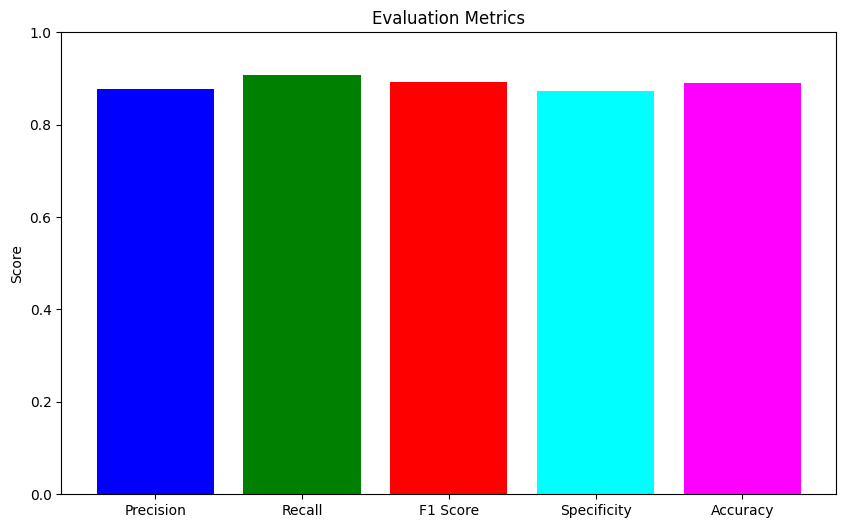

In [19]:
# Visualize metrics
metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Specificity': specificity,
    'Accuracy': accuracy
}

plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red', 'cyan', 'magenta'])
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.show()

In [20]:
# Save the model
model_path = os.path.join(current_dir, 'cnn_model.h5')
model.save(model_path)

g:\Projects\Sentiment Analysis using Neural Networks\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
import json
from keras.preprocessing.text import tokenizer_from_json

# Save the tokenizer
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as json_file:
    json_file.write(tokenizer_json)


FileNotFoundError: [Errno 2] No such file or directory: 'src\\tokenizer.json'